### **0. Prepare enviroment - Experiment 1**

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import logging
import gc
import math

import time

2025-07-01 15:58:26.440920: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-01 15:58:27.073012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# PREVENT TENSORFLOW FROM ALLOCATING THE TOTALITY OF THE GPU MEMORY
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

        physical_devices = tf.config.list_physical_devices('GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPUs available:", tf.config.list_physical_devices('GPU'))

else:
    print("No GPU devices found. Using CPU only.")

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-07-01 15:58:28.492917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-01 15:58:28.573763: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-01 15:58:28.576684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# Silent warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["TF_XLA_FLAGS"] = "--xla_hlo_profile=false"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

tf.get_logger().setLevel(logging.ERROR)

In [4]:
# Clear Keras backend
tf.keras.backend.clear_session()
gc.collect()

20

### **1. Load training data**

In [5]:
# 1. Subsets para cargar imágenes
subsets = ['TC_Canon_RAD_HURJC_train', 'TC_Canon_CZC_HURJC_train', 'TC_Canon_MIN_HURJC_train']

# 2. Nombre del conjunto (solo un string, para las carpetas del modelo)
subset_name = 'TC_Canon_CZC_RAD_MIN_HURJC_train'

# 2. Inicializa listas vacías
images_path = []
labels = []

# 3. Carga datos de los 3 subsets
subsets_path = 'subsets_v0'  

for s in subsets:
    # Carpeta de imágenes
    subset_path = os.path.join(subsets_path, s) 
    images_subset = [os.path.join(subset_path, image_name) for image_name in os.listdir(subset_path)]

    # Filtrar imágenes que realmente existen (por si hay nombres en el CSV que no se copiaron bien)
    images_subset = [img_path for img_path in images_subset if os.path.exists(img_path)]
    images_path.extend(images_subset)
    
    # Metadata
    df = pd.read_csv(os.path.join(subsets_path, s + '.csv'))

    # Extraer etiquetas
    label_dict = dict(zip(df['rx_cod'], df['label_CalTend']))
    labels_subset = [
    label_dict[
        os.path.splitext(os.path.basename(img_path))[0]
    ]
    for img_path in images_subset
]
    labels.extend(labels_subset)

# 4. Convertir a array
images_path = np.array(images_path)
y = np.array(labels)

# 5. Imprimir resumen
print('Images:', len(images_path))
print('Labels:', y.shape)


Images: 3768
Labels: (3768,)


### **2. Prepare K-fold sub-subsets**

In [6]:
# Stratified splitting of training dataset for k-fold cross validation

def stratified_split_lists (X_paths, y_labels, n_folds):
    
    X_paths = np.array(X_paths)
    
    fold_array_size = len(X_paths) // n_folds
    arrays_list = []

    for _ in range(n_folds - 1):
        hold_out_size = len(X_paths) - fold_array_size
        X_nfold, X_hold_out, y_nfold, y_hold_out = train_test_split(X_paths, y_labels,
                                                                    train_size=fold_array_size,
                                                                    stratify=y_labels, random_state=42)
        arrays = (X_nfold.tolist(), y_nfold.tolist())
        arrays_list.append(arrays)

        X_paths = X_hold_out
        y_labels = y_hold_out

    arrays = (X_hold_out.tolist(), y_hold_out.tolist())
    arrays_list.append(arrays)

    return arrays_list

In [7]:
# Stratified arrays splitting into n_folds
X_y_folds = stratified_split_lists (X_paths=images_path, y_labels=y, n_folds=5)

### **3. Training models**

In [8]:
# Data Generator from Keras Sequence

from tensorflow.keras.utils import Sequence, to_categorical

class DataGenerator(Sequence):


    def __init__(self, image_paths, labels, batch_size, img_size, shuffle=True, seed=42):

        """
        Initialization
        
        Parameters:
        -----------
        image_paths : list
            List of image paths
        labels : array-like
            Array of integer labels (e.g., 0, 1, 2, ...).
        batch_size : int
            Size of the batch.
        img_size : tuple
            Image size (height, weight).
        shuffle : bool, optional
            Shuffle after each epoch.
        seed : int, optional
            Random seed.
        """
        self.image_paths = image_paths
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.img_size = img_size
        
        self.n_classes = len(np.unique(self.labels))
        if self.n_classes == 2:
            self.n_classes = 1
            
        self.shuffle = shuffle
        self.seed = seed
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()


    
    def __len__(self):
        # Number of batches per epoch
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    
    def __getitem__(self, index):
        
        # Generating indices for the current epoch
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start:end]

        # Batch creation
        batch_image_paths = [self.image_paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]
        
        X, y = self.__data_generation(batch_image_paths, batch_labels)
        
        return X, y

    
    def on_epoch_end(self):
        # Shuffle indexes after each epoch
        if self.shuffle:
            np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

            
    def __data_generation(self, batch_image_paths, batch_labels):
        
        # Initialize arrays to store batch data
        X = np.empty((len(batch_image_paths), self.img_size[0], self.img_size[1], 3), dtype=np.float32)
        y = np.empty((len(batch_image_paths),), dtype=int)
    
        # Iterate over each .npy image in the batch
        for i, path in enumerate(batch_image_paths):
            # Load preprocessed image from .npy file
            X_ = np.load(path)
            X[i] = X_
            y[i] = batch_labels[i]
    
        # Convert labels to one-hot encoding if there is more than two classes
        if self.n_classes > 2:
            y = to_categorical(y, num_classes=self.n_classes)
            
        return X, y

In [9]:
# Training class

class My_Custom_Model:


    def __init__ (self, train_gen, val_gen, img_size,
                  model_conv, freeze, top_m, neurons_last_layer, initializer_seed, optimizer, lr, loss_function, activation, metrics,
                  patience, batch_size, epochs, model_dir, model_fold, print_report, subset):

        self.train_gen = train_gen
        self.val_gen = val_gen
        self.img_size = img_size
        self.model_conv = model_conv
        self.freeze = freeze
        self.top_m = top_m
        self.neurons_last_layer = neurons_last_layer
        self.initializer_seed = initializer_seed
        self.optimizer = optimizer
        self.lr = lr
        self.lossf= loss_function
        self.activation = activation
        self.metrics= metrics
        self.patience= patience
        self.batch_size= batch_size
        self.epochs= epochs
        self.model_dir = model_dir
        self.model_fold = model_fold
        self.print_report= print_report
        self.subset = subset

        self.model_path = ('model_conv_' + str(model_conv) + '_freeze_' + str(freeze) + '_top_m_' + str(top_m) +
                           '_neurons_last_layer_' + str(neurons_last_layer) + '_optimizer_' + str(optimizer) +
                           '_loss_function_' + str(loss_function) + '_activation_' + str(activation[0]) +
                           '_initializer_seed_' + str(initializer_seed) + '_lr_' + str(lr) +
                           '_epochs_' + str(epochs) + '_batch_size_' + str(batch_size) + '_patience_' + str(patience) +
                           '_subset_' + str(subset))

        self.model_dir_model_path_model_fold = os.path.join(self.model_dir, self.model_path, 'FOLD_' + str(self.model_fold))

        if os.path.exists(self.model_dir_model_path_model_fold):
            print(f'[WARNING] self.model_dir_model_path_model_fold {self.model_dir_model_path_model_fold} already exists')
            raise SystemExit  # O usa `sys.exit()` si prefieres
        else:
            os.makedirs(self.model_dir_model_path_model_fold)


    def base_model_tuning (self):
        # Importing the model and freezing/unfreezing layers
        # freeze True would freeze all the layers, freeze False would unfreeze all layers
        # and freeze int would freeze layers from 0 up to (but not including) that int

        if self.model_conv == 'IV3':
             self.base_model= keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'VGG16':
             self.base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'VGG19':
             self.base_model = keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'ResNet50':
             self.base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'ResNet101':
             self.base_model = keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'ResNet152':
             self.base_model = keras.applications.ResNet152(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'ResNet50V2':
             self.base_model = keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'ResNet101V2':
             self.base_model = keras.applications.ResNet101V2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'ResNet152V2':
             self.base_model = keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'Xception':
             self.base_model = keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'InceptionResNetV2':
            self.base_model = keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'DenseNet121':
            self.base_model = keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'DenseNet169':
            self.base_model = keras.applications.DenseNet169(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'DenseNet201':
            self.base_model = keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'MobileNet':
            self.base_model = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'MobileNetV2':
            self.base_model = keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'NASNetMobile':
            self.base_model = keras.applications.NASNetMobile(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'NASNetLarge':
            self.base_model = keras.applications.NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'EfficientNetB0':
            self.base_model = keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'EfficientNetB1':
            self.base_model = keras.applications.EfficientNetB1(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'EfficientNetB2':
            self.base_model = keras.applications.EfficientNetB2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'EfficientNetB3':
            self.base_model = keras.applications.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'EfficientNetB4':
            self.base_model = keras.applications.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'EfficientNetB5':
            self.base_model = keras.applications.EfficientNetB5(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'EfficientNetB6':
            self.base_model = keras.applications.EfficientNetB6(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'EfficientNetB7':
            self.base_model = keras.applications.EfficientNetB7(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

        
        if self.freeze == False:
             for layer in self.base_model.layers:
                    layer.trainable = True
             #print('None of the layers frozen')

        elif self.freeze == True:
            for layer in self.base_model.layers:
                layer.trainable = False
            #print ('All layers frozen')
        
        else:
             num_layers = len(self.base_model.layers)
             unfreeze_count = math.ceil(num_layers * self.freeze)
             unfreeze_from = num_layers - unfreeze_count
            
             for layer in model.layers[:unfreeze_from]:
                 layer.trainable = False
                 #print('Layer ' + layer.name + ' frozen...')
            
             for layer in model.layers[unfreeze_from:]:
                 layer.trainable = True
                 #print('Layer ' + layer.name + ' not frozen...')


    def model_top_setting (self):
        # Definition of the model_top, review the architectures of the classifiers before each test

        initializer_1 = tf.keras.initializers.he_normal(seed=self.initializer_seed)
        initializer_2 = tf.keras.initializers.GlorotNormal(seed=self.initializer_seed)

        if self.top_m == 'GMP':
             self.model_top = keras.models.Sequential()
             self.model_top.add (self.base_model)
             self.model_top.add (keras.layers.GlobalMaxPooling2D())
        if self.top_m == 'GAP':
             self.model_top = keras.models.Sequential()
             self.model_top.add (self.base_model)
             self.model_top.add (keras.layers.GlobalAveragePooling2D())
        if self.top_m == 'FD':
             self.model_top = keras.models.Sequential()
             self.model_top.add (self.base_model)
             self.model_top.add (keras.layers.Flatten())
             self.model_top.add (keras.layers.Dense(128, activation='relu', kernel_initializer=initializer_1))
             self.model_top.add (keras.layers.Dense(64, activation='relu', kernel_initializer=initializer_1))

        if self.top_m == 'GMP + Dropout':
            self.model_top = keras.models.Sequential()
            self.model_top.add (self.base_model)
            self.model_top.add (keras.layers.GlobalMaxPooling2D())
            self.model_top.add(keras.layers.Dropout(0.2))
            self.model_top.add (keras.layers.Dense(256, activation='relu', kernel_initializer=initializer_1))
            self.model_top.add(keras.layers.Dropout(0.2))

        if self.top_m == 'FD + 2 capas':
            self.model_top = keras.models.Sequential()
            self.model_top.add (self.base_model)
            self.model_top.add (keras.layers.Flatten())
            self.model_top.add (keras.layers.Dense(256, activation='relu', kernel_initializer=initializer_1))
            self.model_top.add (keras.layers.Dense(64, activation='relu', kernel_initializer=initializer_1))

        if self.neurons_last_layer == 1:
             self.model_top.add (keras.layers.Dense(self.neurons_last_layer, activation='sigmoid', kernel_initializer=initializer_2))
             if self.lossf == 'categorical_crossentropy':
                 print(f'Categorical_crossentropy changed for binary_crossentropy')
                 self.lossf == 'binary_crossentropy'
        
        if self.neurons_last_layer > 1:
             self.model_top.add (keras.layers.Dense(self.neurons_last_layer, activation=self.activation, kernel_initializer=initializer_2))
             if self.lossf == 'binary_crossentropy' and self.activation == 'softmax':
                 print(f'Binary_crossentropy changed for categorical_crossentropy')
                 self.lossf == 'categorical_crossentropy'
        
        return self.model_top


    def model_compilation (self):
        # Model compilation

        if self.optimizer == 'SGD':
            self.opt= keras.optimizers.SGD (learning_rate= self.lr)
        elif self.optimizer == 'RMSprop':
            self.opt= keras.optimizers.RMSprop (learning_rate= self.lr)
        elif self.optimizer == 'ADAM':
            self.opt= keras.optimizers.Adam (learning_rate= self.lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        elif self.optimizer == 'ADADELTA':
            self.opt= keras.optimizers.Adadelta (learning_rate= self.lr)
        elif self.optimizer == 'ADAGRAD':
            self.opt= keras.optimizers.Adagrad (learning_rate= self.lr)
        elif self.optimizer == 'ADAMAX':
            self.opt= keras.optimizers.ADAMAX (learning_rate= self.lr)
        elif self.optimizer == 'NADAM':
            self.opt= keras.optimizers.Nadam (learning_rate= self.lr)
        elif self.optimizer == 'FTRL':
            self.opt= keras.optimizers.Ftrl (learning_rate= self.lr)

        self.model= self.model_top
        self.model.compile (optimizer=self.opt, loss=self.lossf, metrics= self.metrics)

        return self.model   


    def model_fit(self):
        
        # Training model
        best_model_path = os.path.join(self.model_dir_model_path_model_fold, 'best_model_epoch_{epoch:02d}_val_loss_{val_loss:.4f}_val_acc_{val_accuracy:.4f}.h5')
        
        checkpoint1 = keras.callbacks.ModelCheckpoint(best_model_path, save_best_only=True, monitor='val_loss')
        checkpoint2 = keras.callbacks.ModelCheckpoint(best_model_path, save_best_only=True, monitor='val_accuracy')
        early_stop  = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)

        self.history = self.model.fit(self.train_gen,
                                      validation_data=self.val_gen,
                                      epochs=self.epochs,
                                      callbacks=[checkpoint1, checkpoint2, early_stop],
                                      workers=4,
                                      use_multiprocessing=True,
                                      verbose=1)
        
        history_path =     os.path.join(self.model_dir_model_path_model_fold, 'history.npy')
        final_model_path = os.path.join(self.model_dir_model_path_model_fold, 'final_model.h5')
        
        np.save(history_path, self.history.history)
        self.model.save(final_model_path)

    
    def training_loss_curves (self):
        # Plottin loss curves

        self.loss_train = self.history.history['loss']
        self.loss_val = self.history.history['val_loss']

        self.epochs = range(0,len(self.history.history['val_loss']))

        self.loss_curve = plt.figure(dpi=300, facecolor='w', edgecolor='w', frameon=True)
        plt.plot(self.epochs, self.loss_train, 'g', label='Training loss')
        plt.plot(self.epochs, self.loss_val, 'b', label='Validation loss')
        plt.title('Training and Validation loss curves')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        loss_curve_path = os.path.join(self.model_dir_model_path_model_fold, f'LOSS_CURVE_{self.subset}.png')
        #loss_curve_path = os.path.join(self.model_dir_model_path_model_fold, ('LOSS_CURVE_' + 'model_' + self.model_path + '.png'))
        self.loss_curve.savefig(loss_curve_path)


    def training_accuracy_curves (self):
        # Plotting accuracy curves

        self.acc_train = self.history.history['accuracy']
        self.acc_val = self.history.history['val_accuracy']

        self.epochs = range(0,len(self.history.history['val_accuracy']))

        self.acc_curve = plt.figure(dpi=300, facecolor='w', edgecolor='w', frameon=True)
        plt.plot(self.epochs, self.acc_train, 'g', label='Training accuracy')
        plt.plot(self.epochs, self.acc_val, 'b', label='Validation accuracy')
        plt.title('Training and Validation accuracy curves')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')
        acc_curve_path = os.path.join(self.model_dir_model_path_model_fold, f'ACCURACY_CURVE_{self.subset}.png')
        #acc_curve_path = os.path.join(self.model_dir_model_path_model_fold, ('ACCURACY_CURVE_' + 'model_' + self.model_path + '.png'))
        self.acc_curve.savefig(acc_curve_path)


    def generate_report (self):
        # Generate training report

        if print_report == True:
    
            df_params = pd.DataFrame ({'model_conv':    [self.model_conv],
                                       'layers_frozen': [self.freeze],
                                       'model_top': [self.optimizer],
                                       'lr': [self.lr],
                                       'model_n_layers': [self.neurons_last_layer],
                                       'loss_function': [self.lossf],
                                       'initializer_seed': [self.initializer_seed],
                                       'patience': [self.patience],
                                       'batch_size': [self.batch_size],
                                       'epochs': [self.epochs]})
            
            df_params.to_csv (os.path.join(self.model_dir_model_path_model_fold, self.subset + '_params.csv'))
            display(df_params)
            
            print('')

            print(self.model.summary(), '\n')
            print('TRAINING \n')


    def runall (self):
        # Ejecución de todas las funciones,
        # excepto de save_arrays y de combinations_number() que requieren llamada específica

        self.base_model_tuning()
        self.model_top_setting()
        self.model_compilation()
        self.generate_report()
        self.model_fit()
        self.training_loss_curves()
        self.training_accuracy_curves()

        tf.keras.backend.clear_session()  # Clear Keras backend
        gc.collect()

In [10]:
# Set hyperparams

subset = subset_name
k = 5
img_size = (512, 512)
metrics= ['accuracy']
model_dir =  os.path.join ('Models_v0/EXP1', subset_name)
print_report= True

hyperparameters_dict = {
    
    'Params': ['model_conv', 'freeze', 'top_m', 'neurons_last_layer', 'initializer_seed', 'optimizer',
                       'lr', 'loss_function', 'activation', 'patience', 'batch_size', 'epochs', 'Result'],
            

    'Config 0': ['VGG19',       False, 'GMP',           1, 42, 'SGD', 0.005, 'binary_crossentropy', 'sigmoid', 15, 32, 50, False]}

#adam da error all arrays must be of the same size

df_hyperparms = pd.DataFrame (hyperparameters_dict)
df_hyperparms = df_hyperparms.set_index('Params').T
df_hyperparms.to_csv (os.path.join(model_dir, 'df_hyperparms_' + subset + '.csv'))
df_hyperparms

Params,model_conv,freeze,top_m,neurons_last_layer,initializer_seed,optimizer,lr,loss_function,activation,patience,batch_size,epochs,Result
Config 0,VGG19,False,GMP,1,42,SGD,0.005,binary_crossentropy,sigmoid,15,32,50,False


STATIONS: TC_Canon_CZC_RAD_MIN_HURJC_train 

 ------------
|EXPERIMENT 1|
 ------------


FOLD 1
--------------



2025-07-01 15:58:28.937886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-01 15:58:28.942720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-01 15:58:28.945384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

,model_conv,layers_frozen,model_top,lr,model_n_layers,loss_function,initializer_seed,patience,batch_size,epochs
0,VGG19,False,SGD,0.005,1,binary_crossentropy,42,15,32,50



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None 

TRAINING 

Epoch 1/50


2025-07-01 15:58:32.162418: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100663296 exceeds 10% of free system memory.
2025-07-01 15:58:38.386307: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100663296 exceeds 10% of free system memory.
2025-07-01 15:58:38.596548: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100663296 exceeds 10% of free system memory.
2025-07-01 15:58:38.822697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-07-01 15:58:43.212162: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-07-01 15:58:55.435574: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5636f3f0b570 initialized for platform CUDA (this does not guarantee

 1/95 [..............................] - ETA: 1:30:07 - loss: 0.7039 - accuracy: 0.6250

2025-07-01 15:59:30.049663: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100663296 exceeds 10% of free system memory.


 2/95 [..............................] - ETA: 4:07 - loss: 0.7062 - accuracy: 0.5625   

2025-07-01 15:59:32.681184: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100663296 exceeds 10% of free system memory.


95/95 [==============================] - ETA: 0s - loss: 0.6809 - accuracy: 0.5813

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 374s 3s/step - loss: 0.6809 - accuracy: 0.5813 - val_loss: 0.6369 - val_accuracy: 0.6362
Epoch 2/50
95/95 [==============================] - 305s 3s/step - loss: 0.6341 - accuracy: 0.6501 - val_loss: 0.6016 - val_accuracy: 0.6812
Epoch 3/50
95/95 [==============================] - 285s 3s/step - loss: 0.5966 - accuracy: 0.6909 - val_loss: 0.6027 - val_accuracy: 0.6852
Epoch 4/50
95/95 [==============================] - 290s 3s/step - loss: 0.5106 - accuracy: 0.7457 - val_loss: 0.4561 - val_accuracy: 0.7950
Epoch 5/50
95/95 [==============================] - 283s 3s/step - loss: 0.4541 - accuracy: 0.7769 - val_loss: 0.4981 - val_accuracy: 0.7500
Epoch 6/50
95/95 [==============================] - 284s 3s/step - loss: 0.3929 - accuracy: 0.8187 - val_loss: 0.4821 - val_accuracy: 0.7646
Epoch 7/50
95/95 [==============================] - 283s 3s/step - loss: 0.3492 - accuracy: 0.8443 - val_loss: 0.4916 - val_accuracy: 0.7632
Epoch 8/50
95/95 [======

,model_conv,layers_frozen,model_top,lr,model_n_layers,loss_function,initializer_seed,patience,batch_size,epochs
0,VGG19,False,SGD,0.005,1,binary_crossentropy,42,15,32,50



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None 

TRAINING 

Epoch 1/50
95/95 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.5612

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 289s 3s/step - loss: 0.6912 - accuracy: 0.5612 - val_loss: 0.6531 - val_accuracy: 0.6189
Epoch 2/50
95/95 [==============================] - 286s 3s/step - loss: 0.6572 - accuracy: 0.6172 - val_loss: 0.6335 - val_accuracy: 0.6521
Epoch 3/50
95/95 [==============================] - 284s 3s/step - loss: 0.6397 - accuracy: 0.6381 - val_loss: 0.6275 - val_accuracy: 0.6653
Epoch 4/50
95/95 [==============================] - 281s 3s/step - loss: 0.6238 - accuracy: 0.6557 - val_loss: 0.6303 - val_accuracy: 0.6587
Epoch 5/50
95/95 [==============================] - 288s 3s/step - loss: 0.5997 - accuracy: 0.6826 - val_loss: 0.6115 - val_accuracy: 0.6866
Epoch 6/50
95/95 [==============================] - 285s 3s/step - loss: 0.5822 - accuracy: 0.6975 - val_loss: 0.5918 - val_accuracy: 0.6932
Epoch 7/50
95/95 [==============================] - 286s 3s/step - loss: 0.5625 - accuracy: 0.7061 - val_loss: 0.5354 - val_accuracy: 0.7437
Epoch 8/50
95/95 [======

,model_conv,layers_frozen,model_top,lr,model_n_layers,loss_function,initializer_seed,patience,batch_size,epochs
0,VGG19,False,SGD,0.005,1,binary_crossentropy,42,15,32,50



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None 

TRAINING 

Epoch 1/50
95/95 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.5615

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 288s 3s/step - loss: 0.6904 - accuracy: 0.5615 - val_loss: 0.6735 - val_accuracy: 0.5737
Epoch 2/50
95/95 [==============================] - 285s 3s/step - loss: 0.5380 - accuracy: 0.7277 - val_loss: 0.5144 - val_accuracy: 0.7317
Epoch 5/50
95/95 [==============================] - 286s 3s/step - loss: 0.4855 - accuracy: 0.7615 - val_loss: 0.4510 - val_accuracy: 0.7782
Epoch 6/50
95/95 [==============================] - 283s 3s/step - loss: 0.4172 - accuracy: 0.8027 - val_loss: 0.4385 - val_accuracy: 0.7875
Epoch 7/50
95/95 [==============================] - 282s 3s/step - loss: 0.5041 - accuracy: 0.7191 - val_loss: 0.6511 - val_accuracy: 0.6096
Epoch 8/50
95/95 [==============================] - 284s 3s/step - loss: 0.4704 - accuracy: 0.7489 - val_loss: 0.5118 - val_accuracy: 0.7583
Epoch 9/50
95/95 [==============================] - 284s 3s/step - loss: 0.3345 - accuracy: 0.8498 - val_loss: 0.5243 - val_accuracy: 0.7463
Epoch 10/50
95/95 [=====

,model_conv,layers_frozen,model_top,lr,model_n_layers,loss_function,initializer_seed,patience,batch_size,epochs
0,VGG19,False,SGD,0.005,1,binary_crossentropy,42,15,32,50



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None 

TRAINING 

Epoch 1/50
95/95 [==============================] - ETA: 0s - loss: 0.6756 - accuracy: 0.5844

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 288s 3s/step - loss: 0.6756 - accuracy: 0.5844 - val_loss: 0.6552 - val_accuracy: 0.6255
Epoch 2/50
95/95 [==============================] - 289s 3s/step - loss: 0.6216 - accuracy: 0.6541 - val_loss: 0.6344 - val_accuracy: 0.6587
Epoch 3/50
95/95 [==============================] - 284s 3s/step - loss: 0.5635 - accuracy: 0.7104 - val_loss: 0.6779 - val_accuracy: 0.6202
Epoch 4/50
95/95 [==============================] - 310s 3s/step - loss: 0.5174 - accuracy: 0.7426 - val_loss: 0.5861 - val_accuracy: 0.6839
Epoch 5/50
95/95 [==============================] - 287s 3s/step - loss: 0.4602 - accuracy: 0.7778 - val_loss: 0.5270 - val_accuracy: 0.7384
Epoch 6/50
95/95 [==============================] - 287s 3s/step - loss: 0.4036 - accuracy: 0.8143 - val_loss: 0.4609 - val_accuracy: 0.7849
Epoch 7/50
95/95 [==============================] - 286s 3s/step - loss: 0.3525 - accuracy: 0.8388 - val_loss: 0.4878 - val_accuracy: 0.7809
Epoch 8/50
95/95 [======

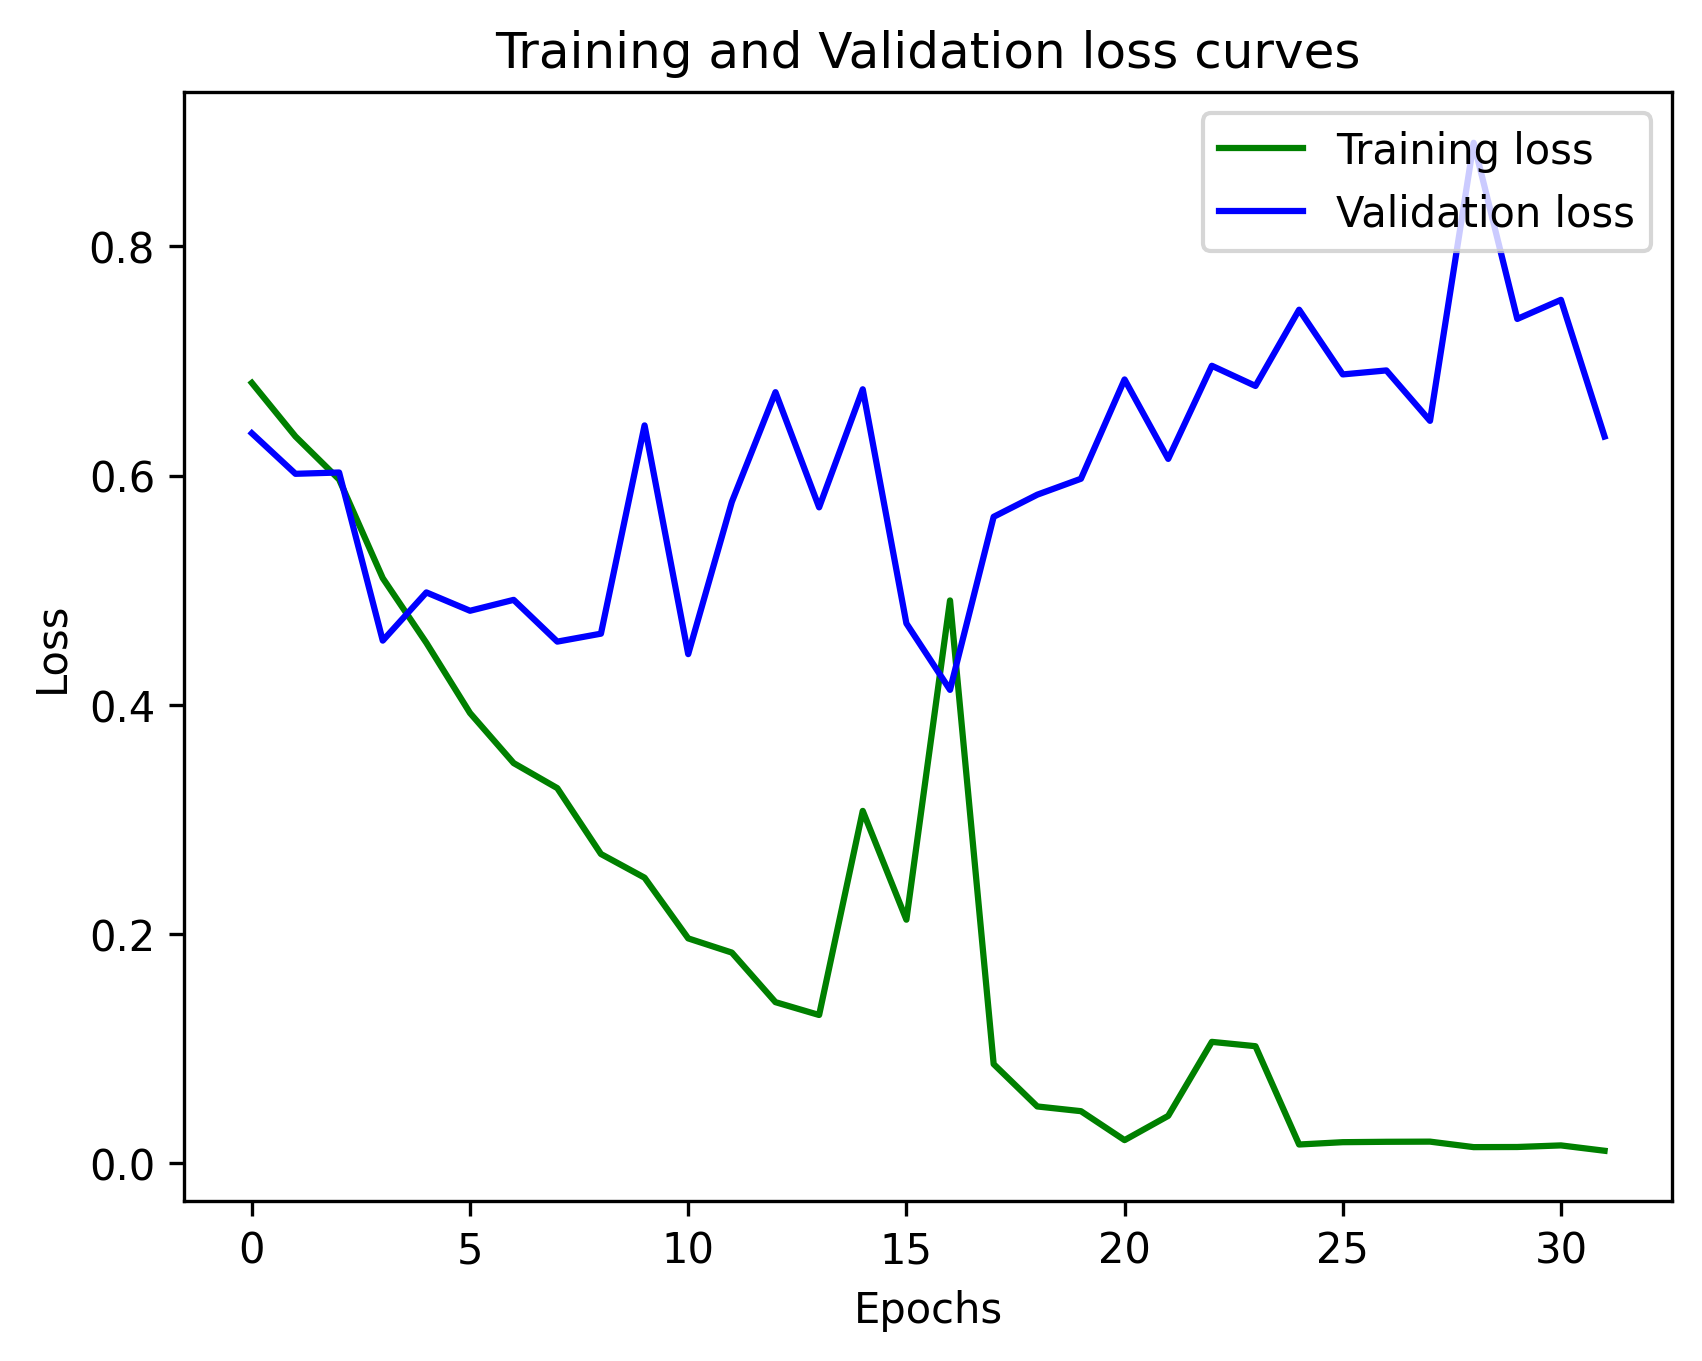

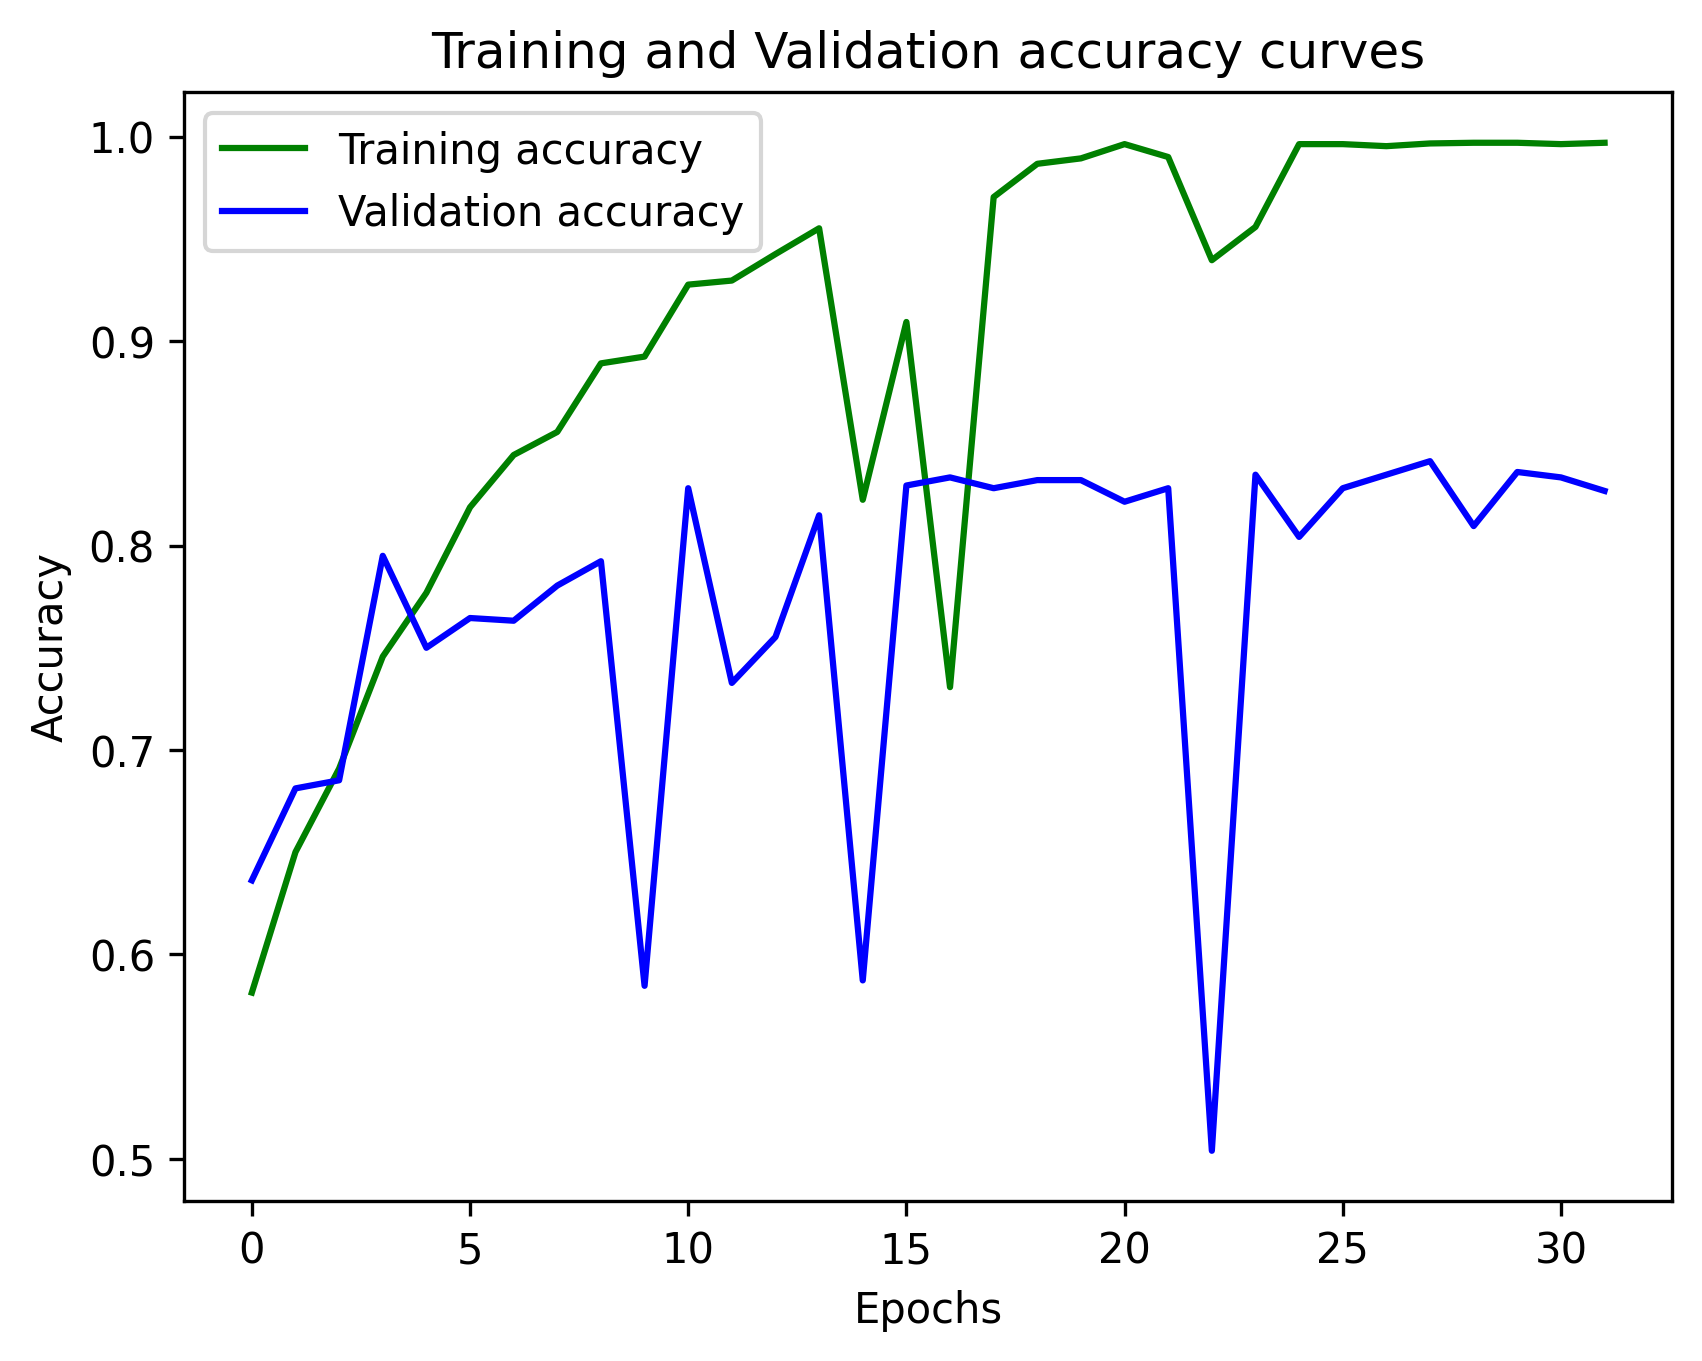

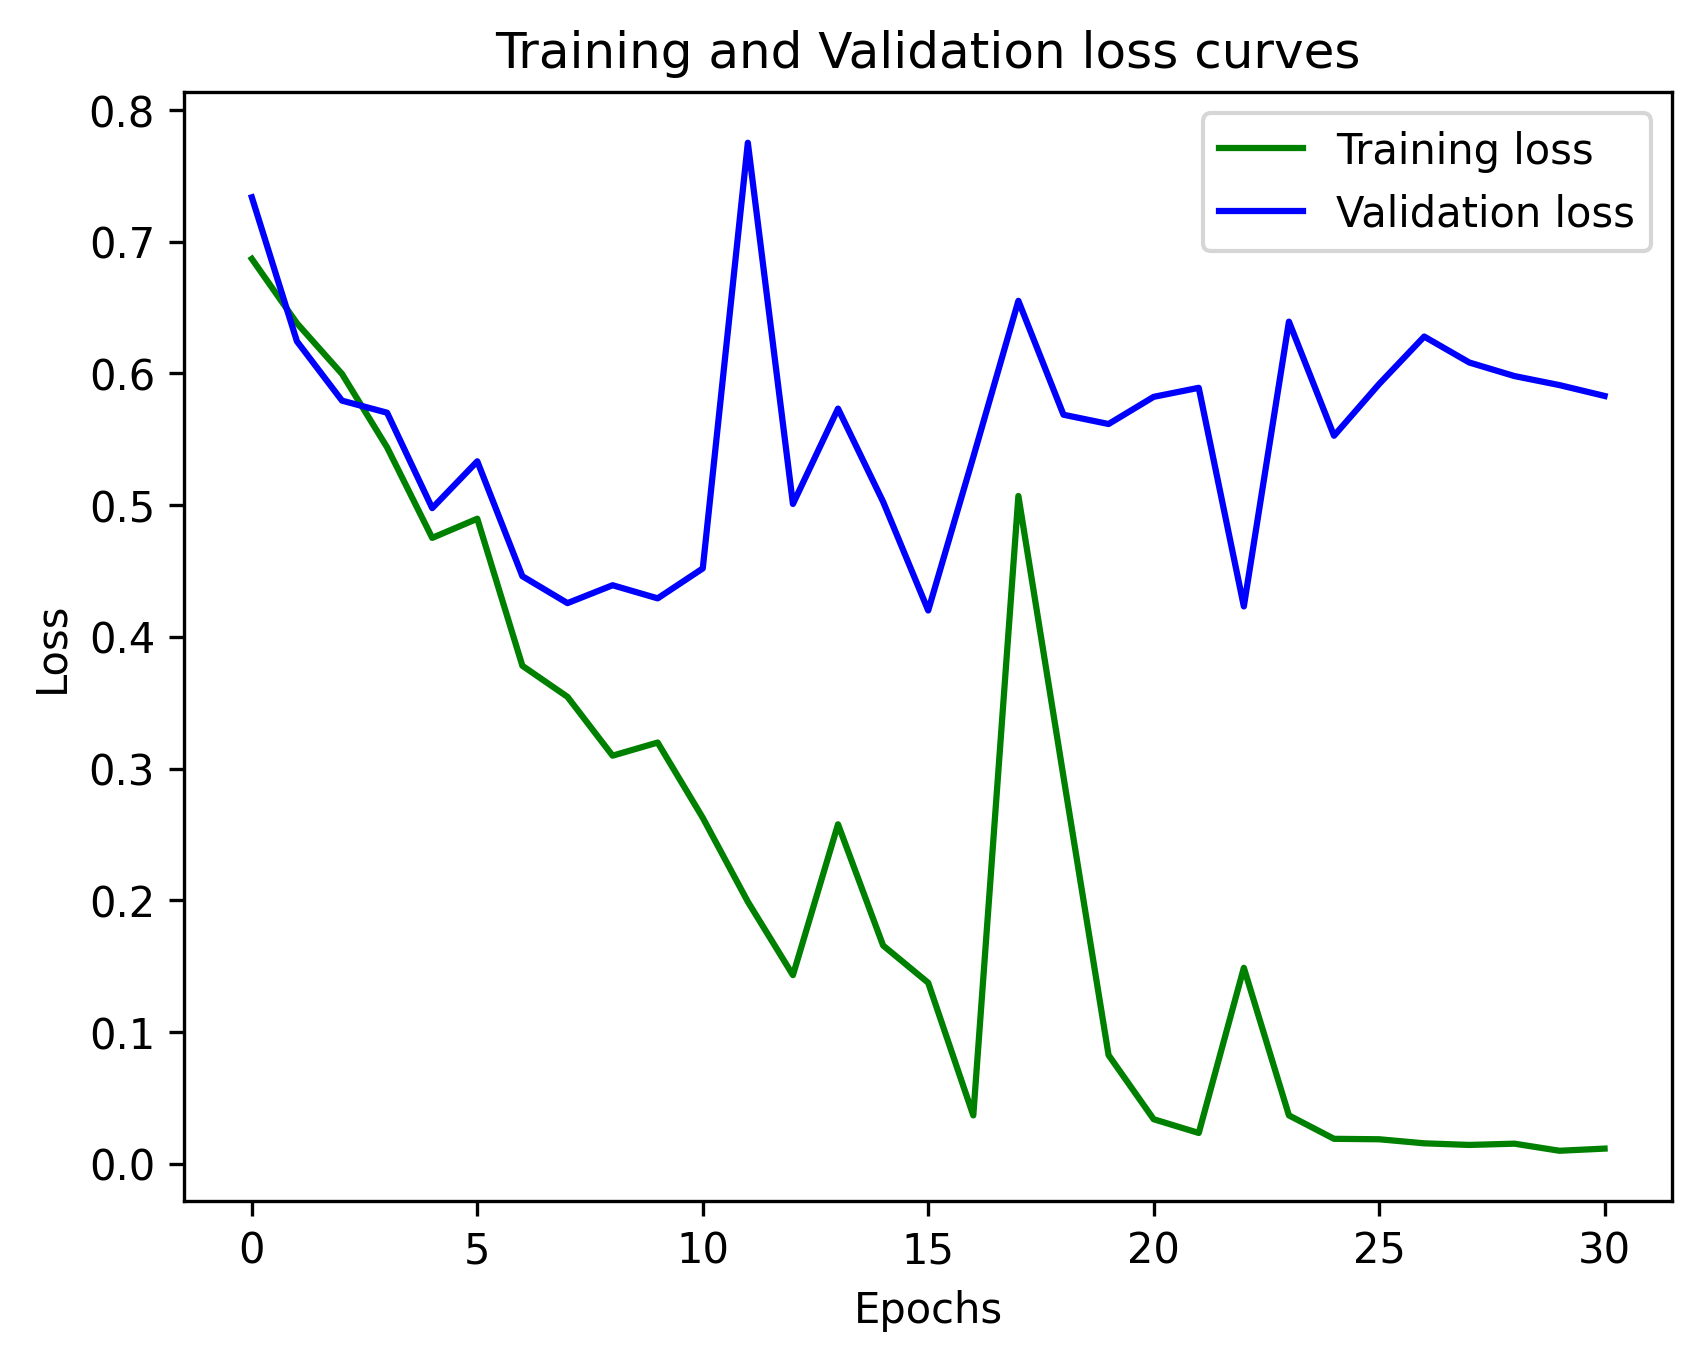

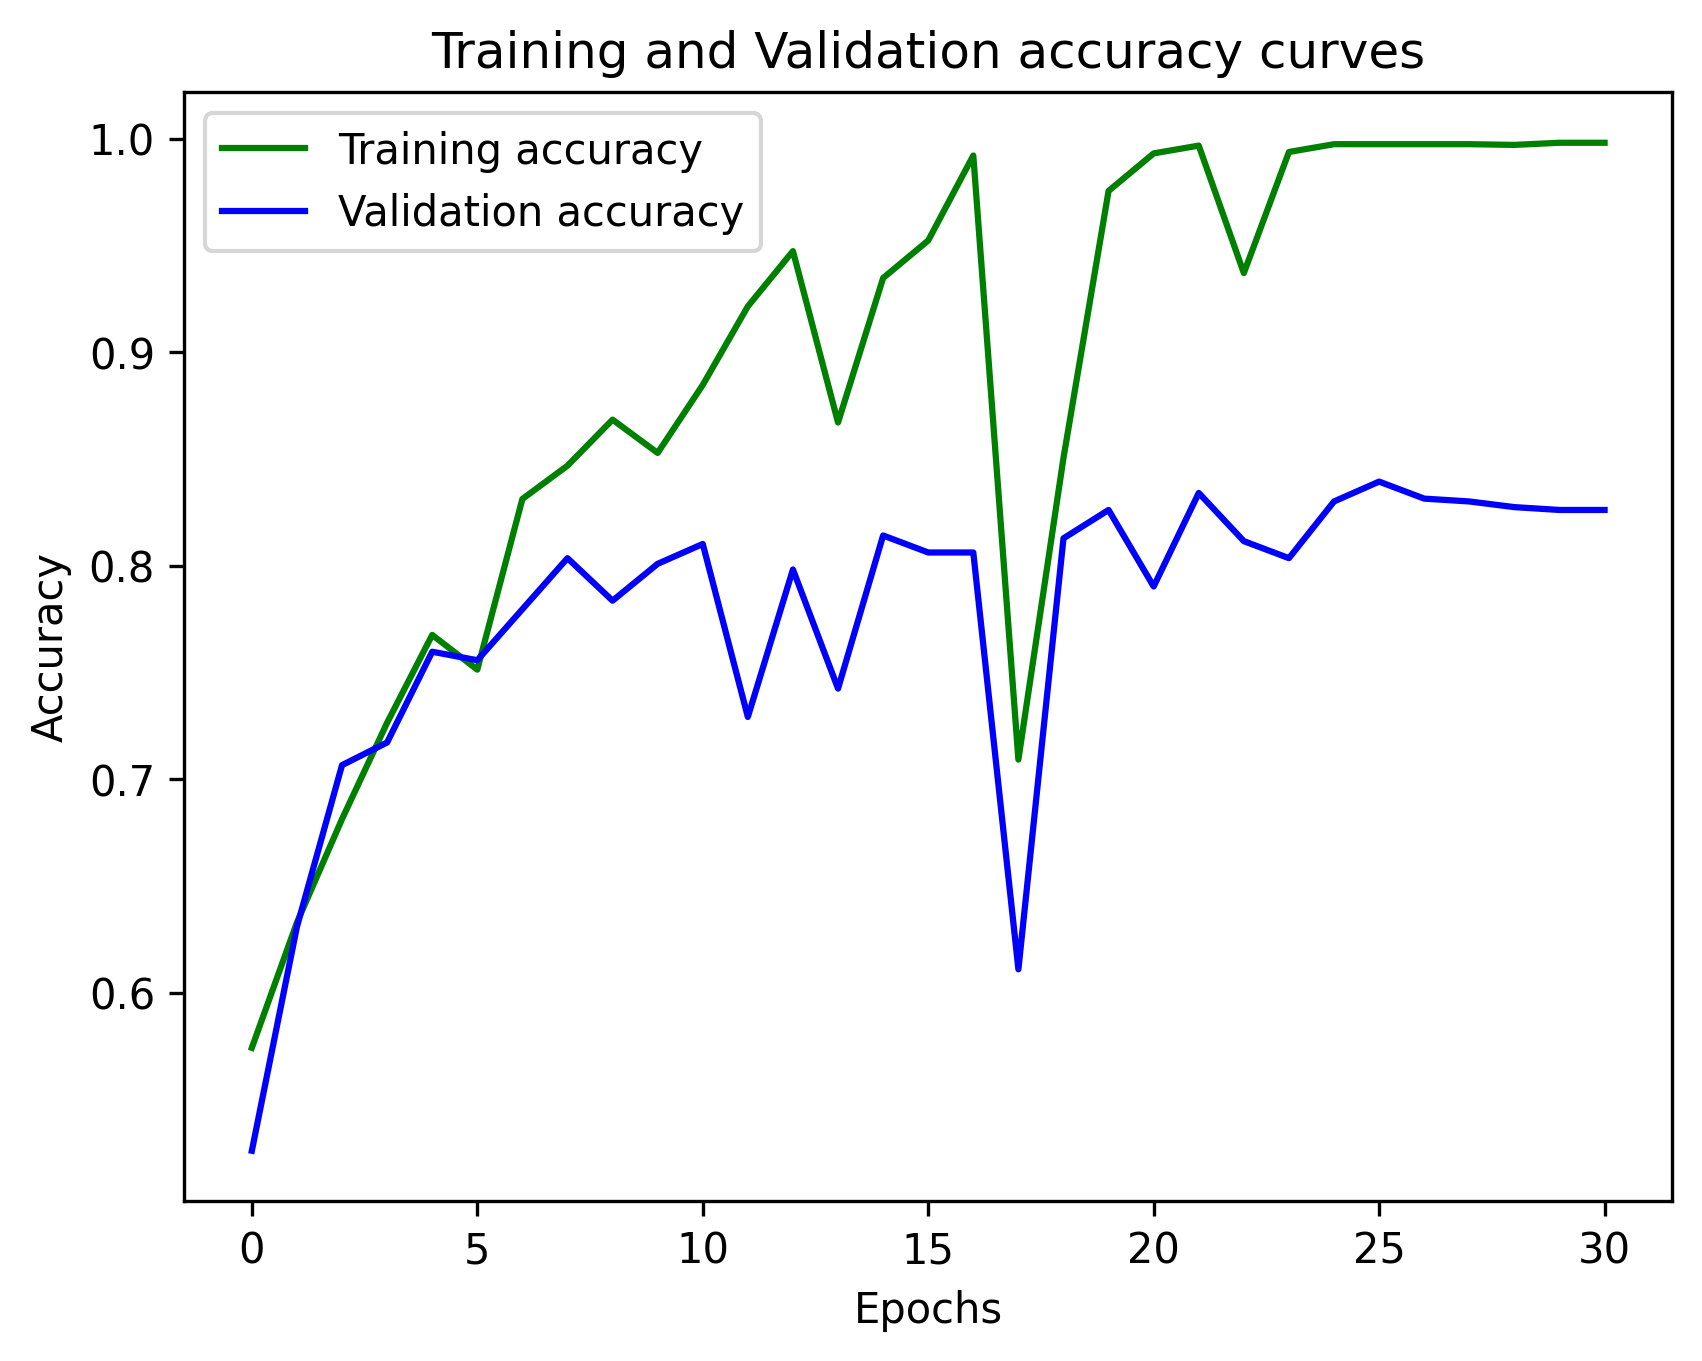

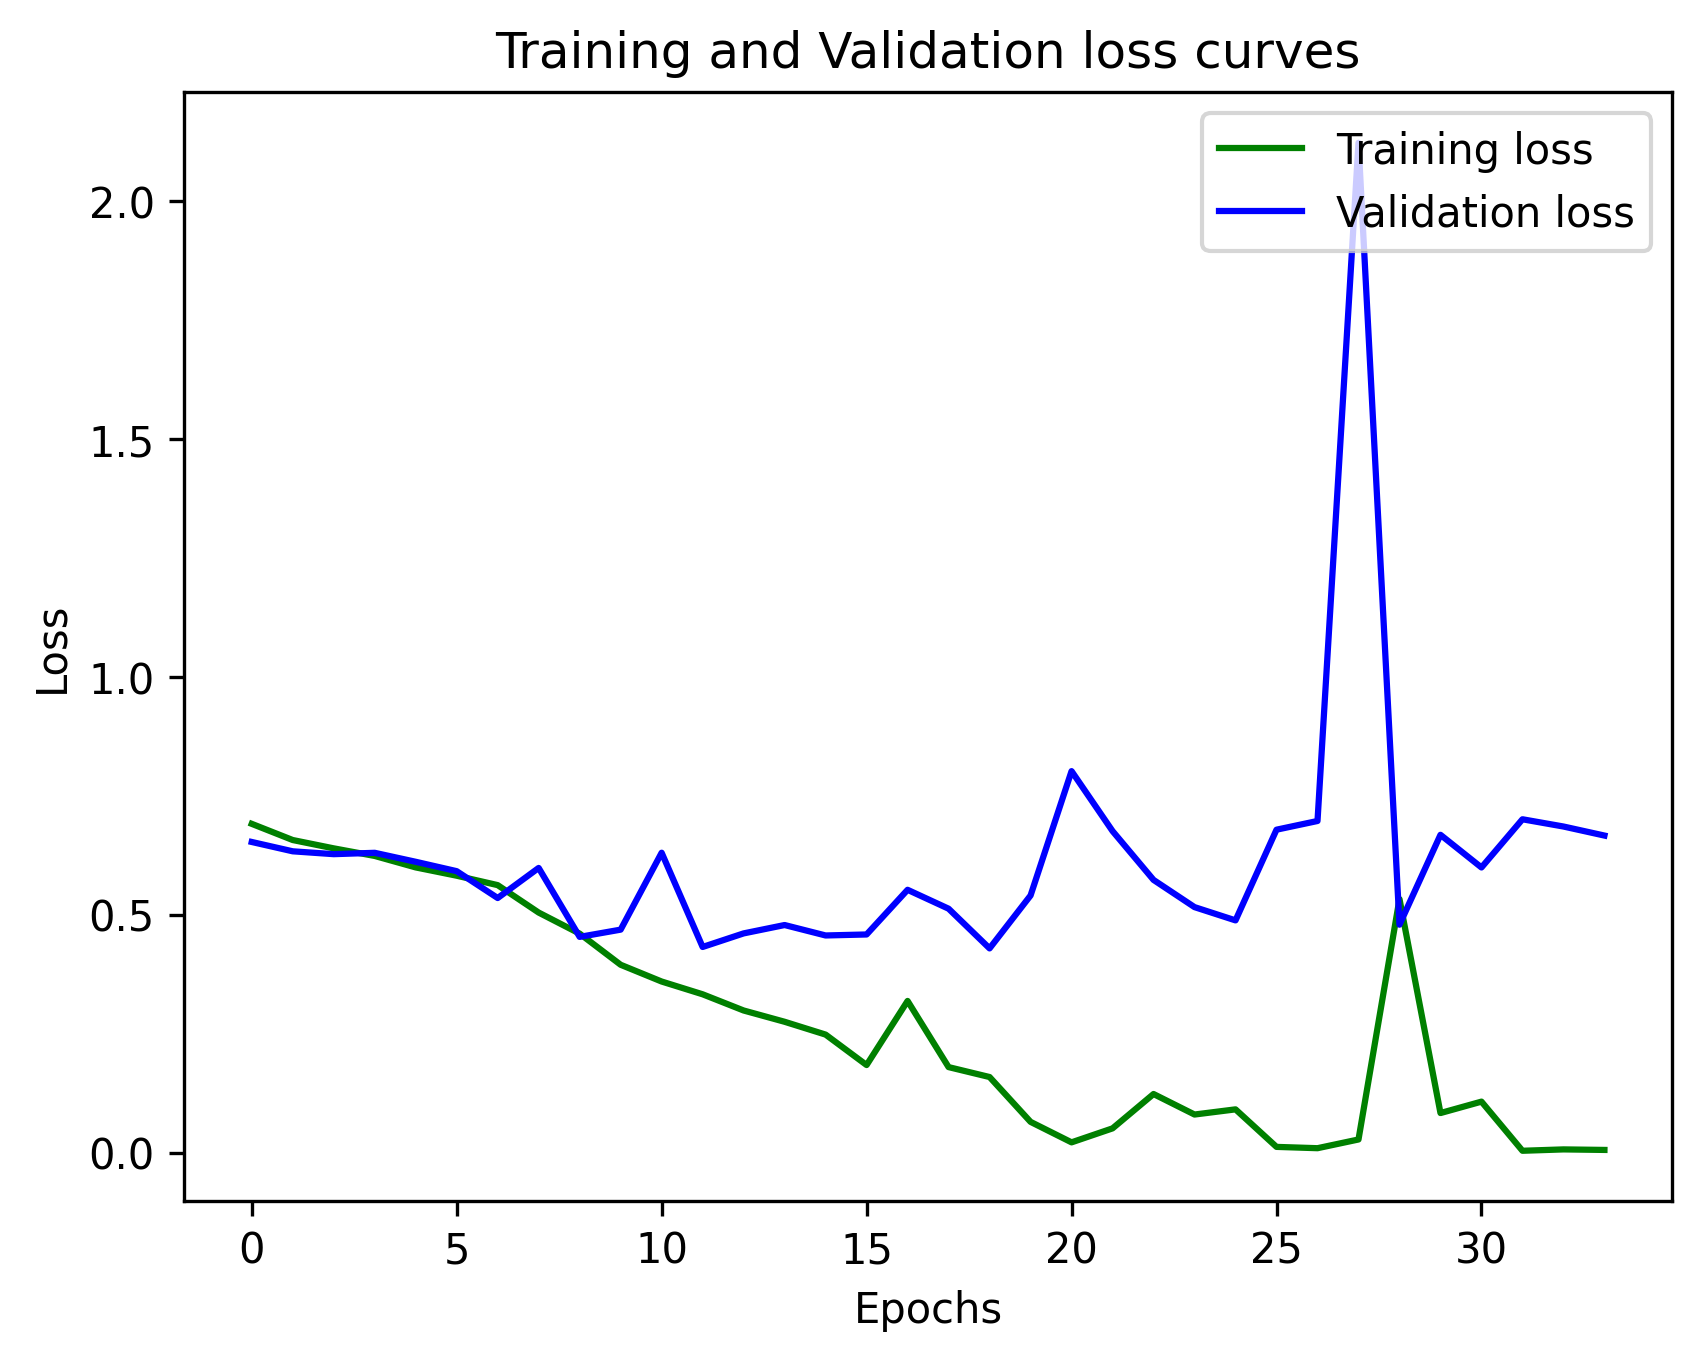

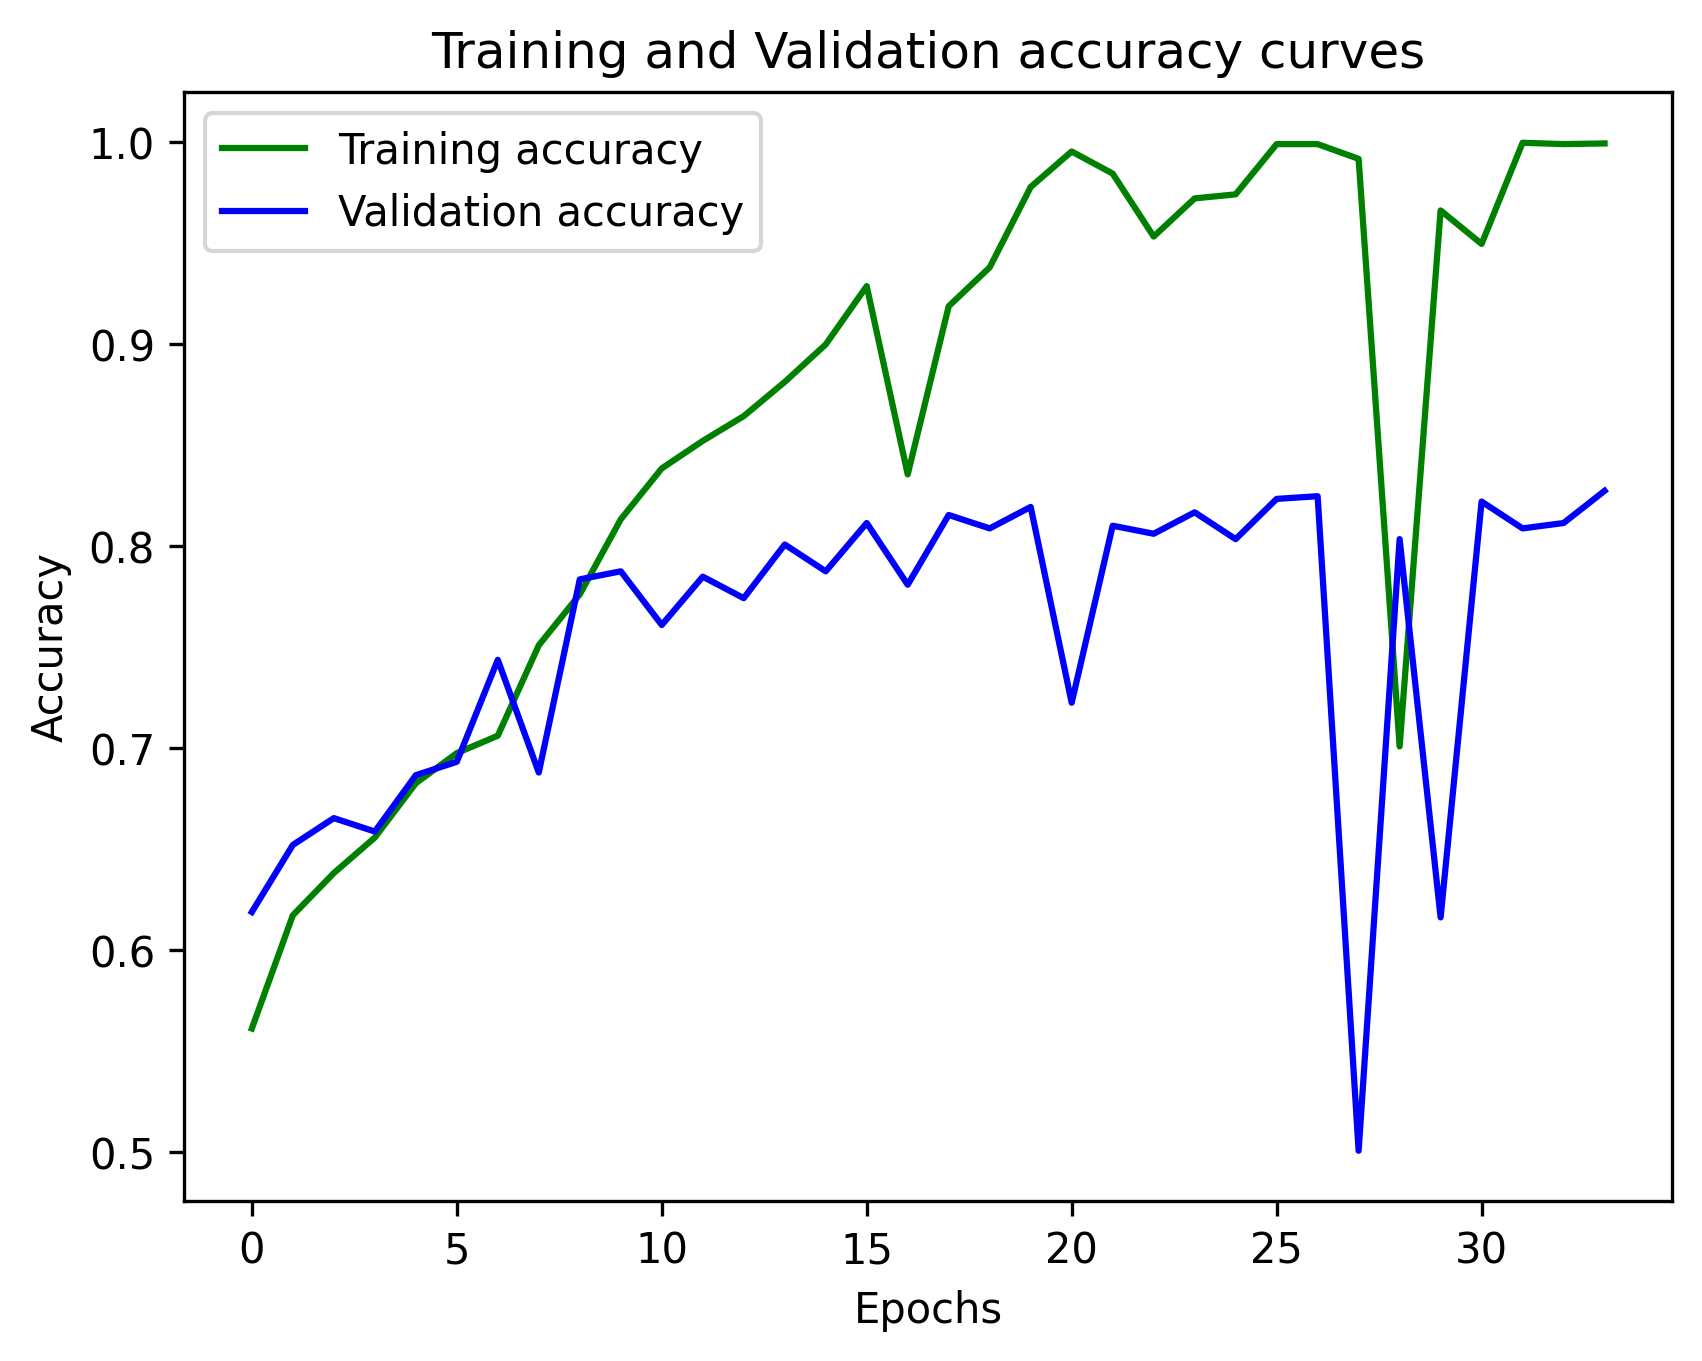

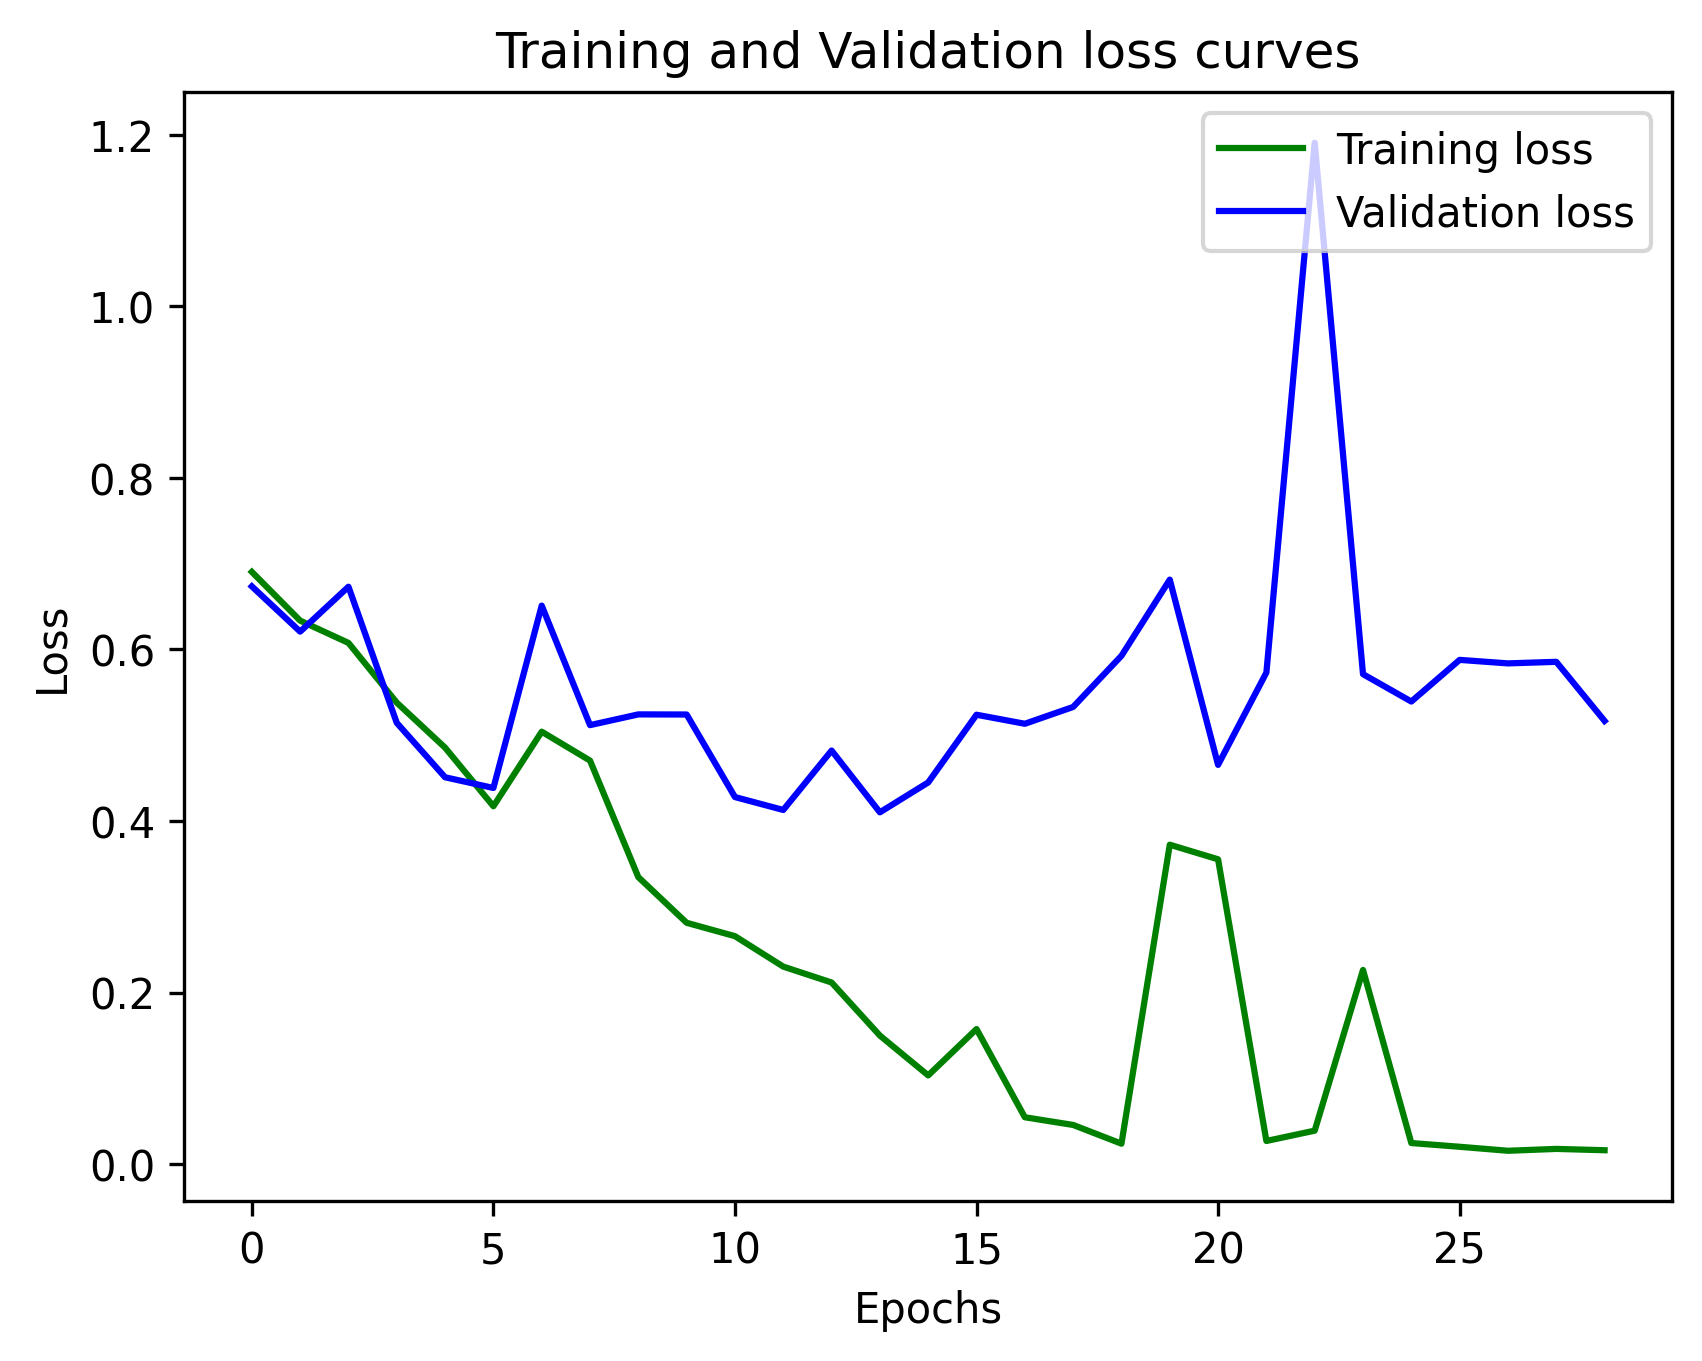

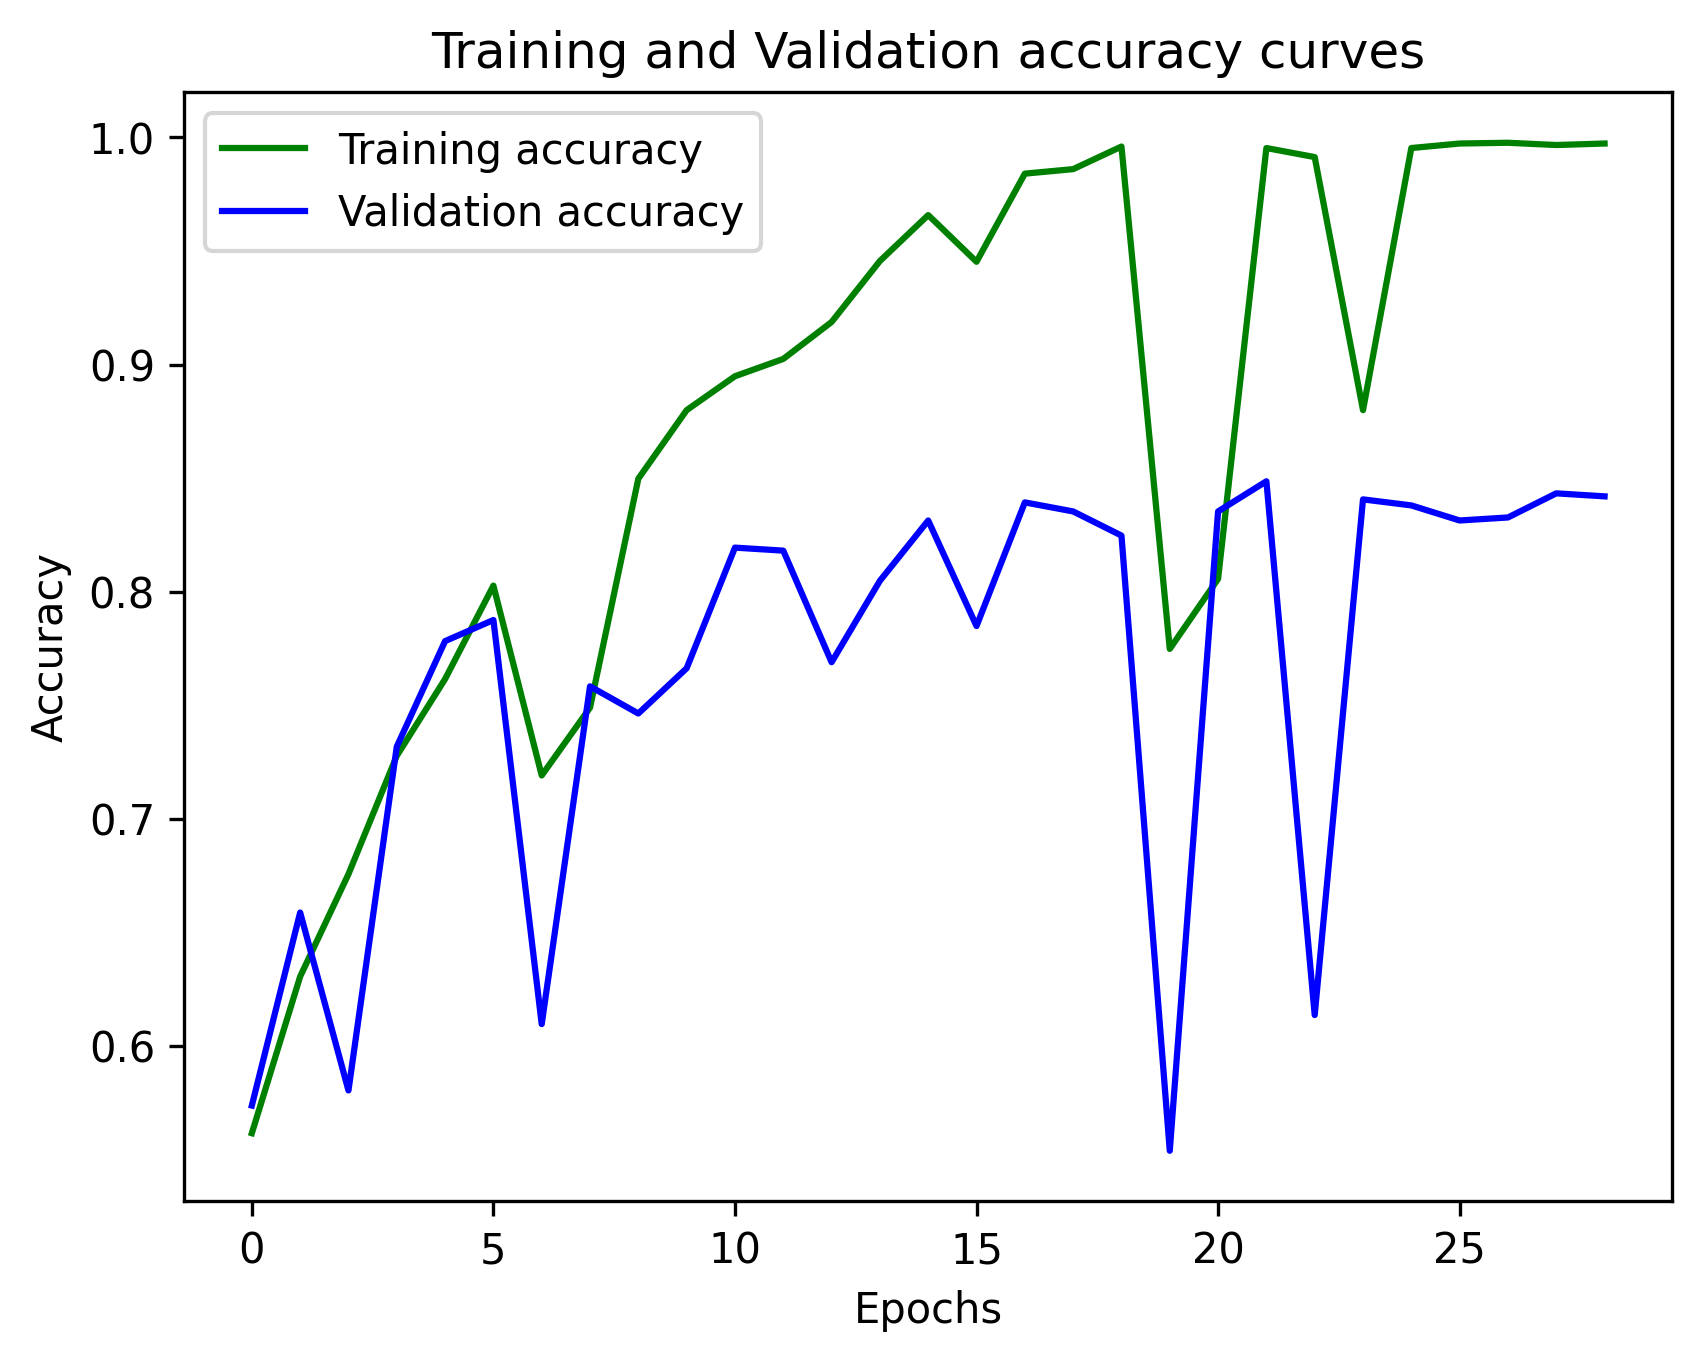

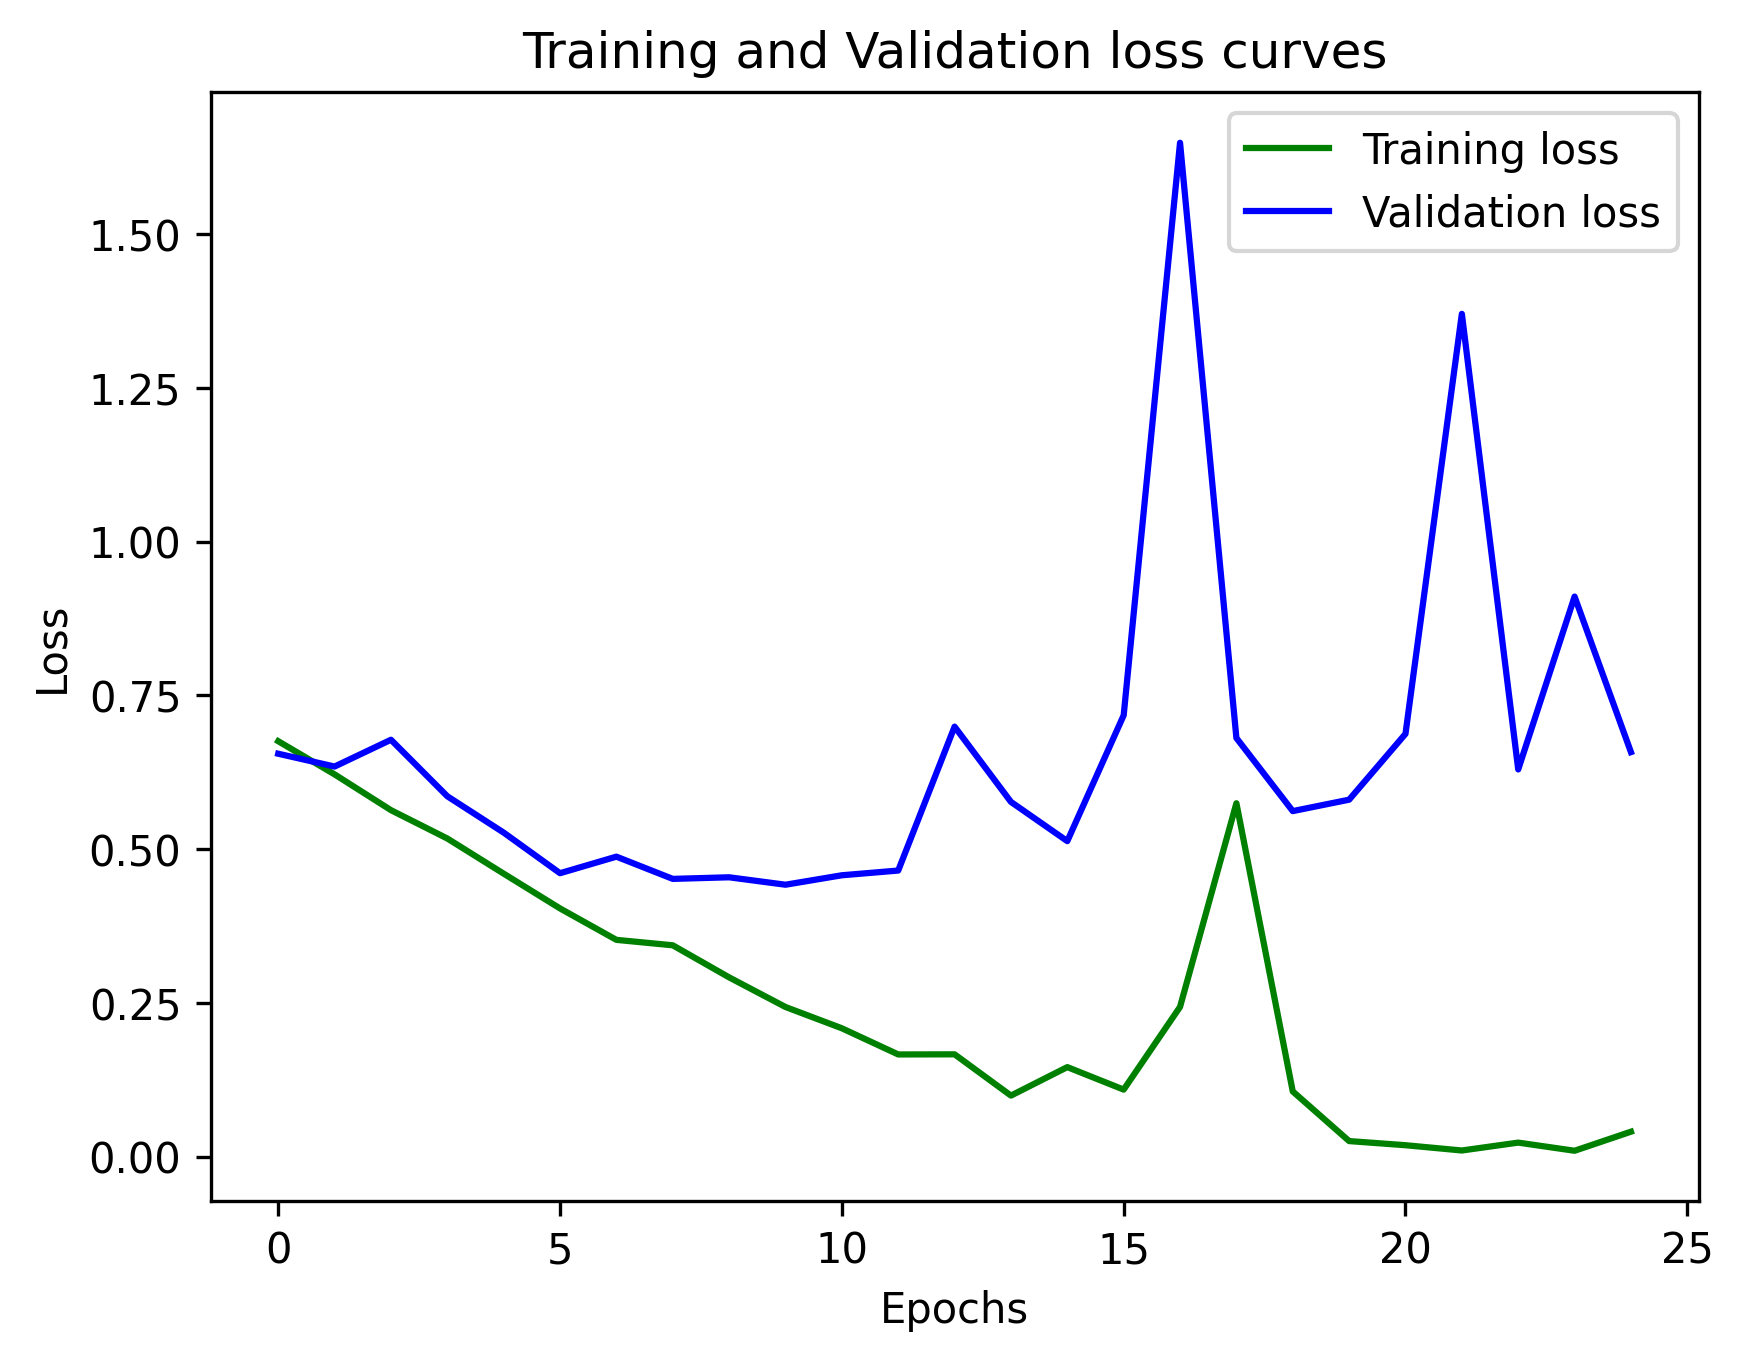

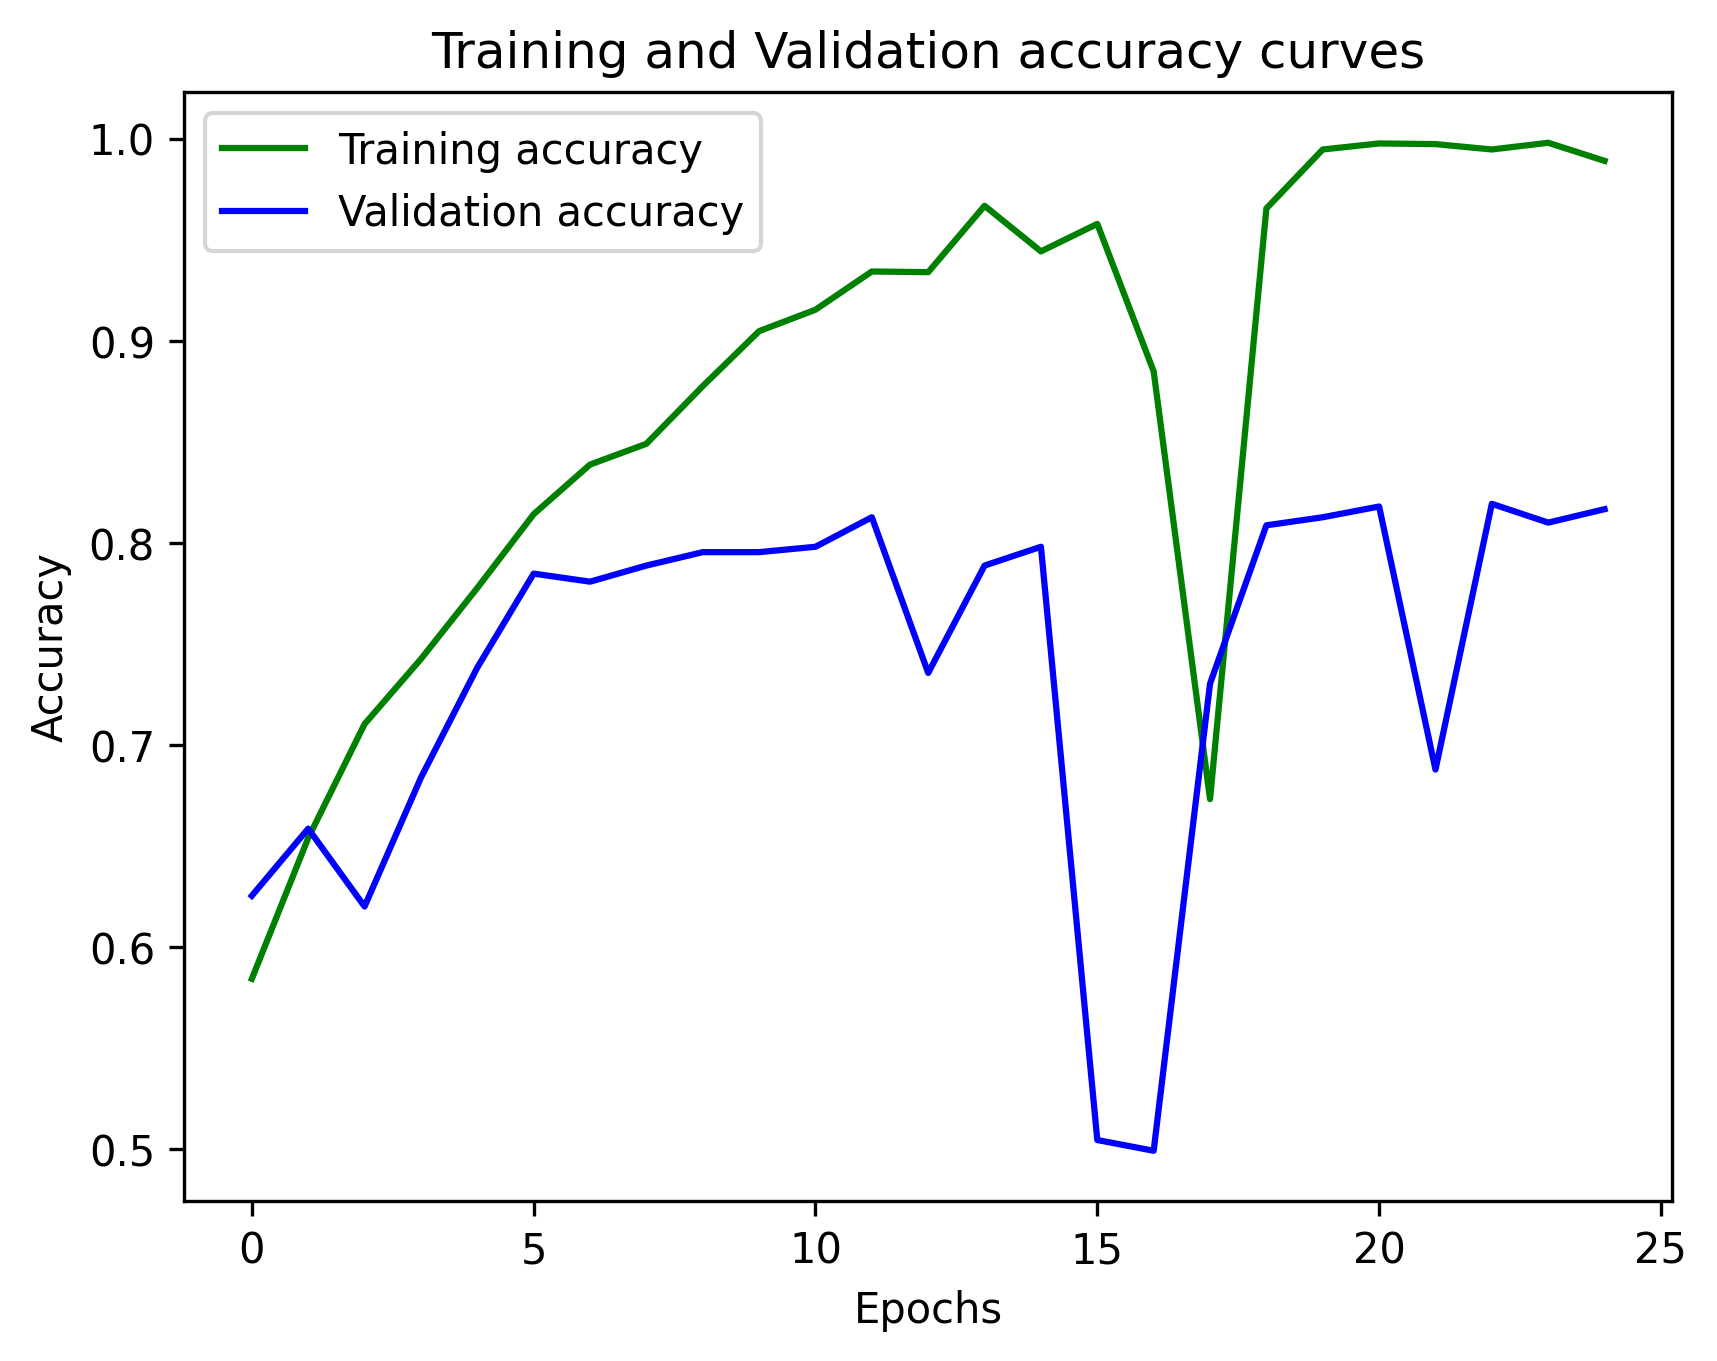

In [11]:
### configs = ['Config 4']

training_times = []

configs = ['Config 0']


print('STATIONS:', subset_name, '\n')
print(' ------------\n|EXPERIMENT 1|\n ------------')

for config in configs:
    
    model_conv         = hyperparameters_dict[config][0]
    freeze             = hyperparameters_dict[config][1]
    top_m              = hyperparameters_dict[config][2]
    neurons_last_layer = hyperparameters_dict[config][3]
    initializer_seed   = hyperparameters_dict[config][4]
    optimizer          = hyperparameters_dict[config][5]
    lr                 = hyperparameters_dict[config][6]
    loss_function      = hyperparameters_dict[config][7]
             = hyperparameters_dict[config][8]
    patience           = hyperparameters_dict[config][9]
    batch_size         = hyperparameters_dict[config][10]
    epochs             = hyperparameters_dict[config][11]
    


    for i in range (k):
        
        fold= i+1
                                            
        a= i
        b= i+1  if i+1 < 5 else i+1-5
        c= i+2  if i+2 < 5 else i+2-5
        d= i+3  if i+3 < 5 else i+3-5
        e= i+4  if i+4 < 5 else i+4-5
    
        print('\n')
        print(f'FOLD {fold}\n--------------\n')
    
        
        # Generate k-fold training and validation sample
        train_paths =  X_y_folds[a][0] + X_y_folds[b][0] + X_y_folds[c][0] + X_y_folds[d][0]
        train_labels = X_y_folds[a][1] + X_y_folds[b][1] + X_y_folds[c][1] + X_y_folds[d][1]
        val_paths =    X_y_folds[e][0]
        val_labels =   X_y_folds[e][1]
    
        train_gen = DataGenerator(image_paths=train_paths, labels=train_labels, batch_size=batch_size, img_size=img_size)
        val_gen   = DataGenerator(image_paths=val_paths,   labels=val_labels,   batch_size=batch_size, img_size=img_size)
    
        model_fold =  f'{fold}'
        

        start = time.time()

        # Train the model
        My_Custom_Model(train_gen, val_gen, img_size,
                        model_conv, freeze, top_m, neurons_last_layer, initializer_seed, optimizer, lr, loss_function, activation,
                        metrics, patience, batch_size, epochs, model_dir, model_fold, print_report, subset).runall()
        end = time.time()
        train_time = end - start
        training_times.append(train_time)